# Enron POI Detector
## 1. Data Exploration
Enron was a big scandal in Wallstreet that embodied greed, pride and fraud in Corporate America. Originally an energy company in Natural Gas, it became big when it started to trade energy in the stock exchange. They used this thing called "Mark-to-Market" pitch that basically allows them to sell their stock by reporting future earnings. Imagine if someone approached you and told you to invest in their company that will make 100 million USD even if their powerplant was not yet built. Naturally, everyone bought it and their prices went up. Long story short, the businesses went bankrupt after reporting huge losses and their investors lost their money. People responsible were called into question to answer for the fraud that they have commited.

## 1.1. Objective of Analysis
The objective of this analysis is create an algorithm that will be able to identify Person of Interests or POI by using their emails and financials.


In [8]:
#!/usr/bin/python
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Counts to describe the dataset
print "Count of People: ", len(my_dataset.keys())
print "Count of Features: ", len(my_dataset["METTS MARK"].keys())
print "Count of POI: ", len(dict([(k,r) for k,r in my_dataset.iteritems() if r['poi'] == 1]))

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list,
                     sort_keys=True, remove_all_zeroes=False)

Count of People:  146
Count of Features:  21
Count of POI:  18


## 1.2. Summary of Dataset
The dataset contains 146 People with 21 Features. The features are split according to Email and Financials of these people. There are 18 People marked as Person of Interest, which includes CEO Jeffrey Skillings, Chairman Kenneth Lay and CFO Andrew Fastow. 

## 1.3. Outlier Investigation
I made a scatter plot with salary and bonus in my axis to see any outliers in the dataset. Upon investigation, I discovered that *TOTAL* is included in the dataset, which is an outlier. In addition, I am seeing *THE TRAVEL AGENCY IN THE PARK* as another entry. Since we are developing a *Person* of of Interest detector, we remove this non-person entry.

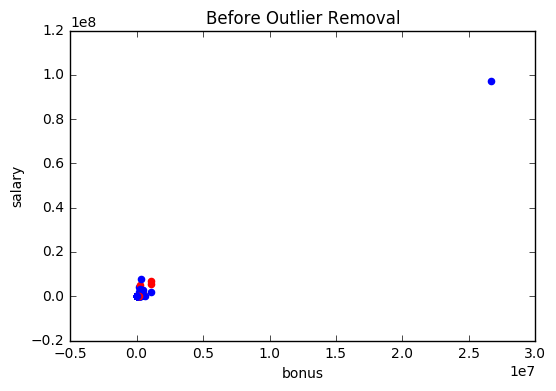

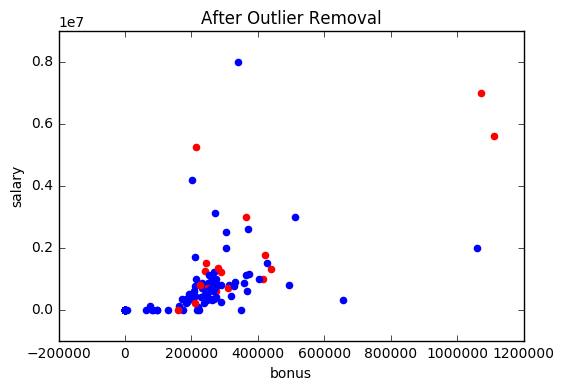

In [9]:
### Task 2: Remove outliers
### Scatterplot function that marks the person of interest in red.
def plotScatter(dat, title, labels=features_list):
    for point in dat:
        poi = point[0]
        if poi == 0:
            plt.scatter( point[1], point[2], color = "blue" )
        else:
            plt.scatter( point[1], point[2], color = "red" )
    plt.ylabel(labels[1])
    plt.xlabel(labels[2])
    plt.title(title)
    plt.show()
    
plotScatter(data, "Before Outlier Removal")
data_dict.pop("TOTAL", 0)
data = featureFormat(my_dataset, features_list, 
                     sort_keys=True, remove_all_zeroes=False)
plotScatter(data, "After Outlier Removal")

## 2.1. Create New Features
When Enron was at the brink of going under, most of the executives tried to get as much money as they could. I suspect that they did this either by giving themselves bonuses or selling their Enron Stocks, which was worthless by then. I test my assumption by looking at 2 latent features. The first is scaled sum of their bonus and salary. The second the amount of emails sent to POI relative to the total 

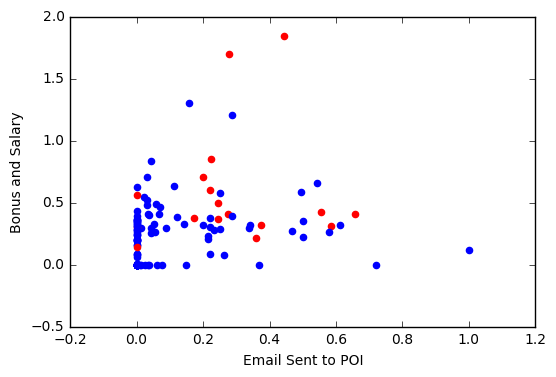

In [10]:
### Task 3: Create new feature(s)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

labels, features = targetFeatureSplit(data)

def doScale(dat):
    scaler = MinMaxScaler()
    rescaled = scaler.fit_transform(dat)
    return rescaled

def doPCA(dat):
    pca = PCA(n_components = 1)
    pca.fit(dat)
    transform = pca.transform(dat)
    return transform

def addNewFeature(dat, num, name):
    new = {}   
    keys = []
    if name not in features_list:
        features_list.append(name)

    for key in dat.keys():
        keys.append(key)
    keys = sorted(keys)
    for i, f in enumerate(keys):
        elem = {}
        elem[name] = num[i][0]
        for key, val in dat[f].items():
            elem[key] = val
        new[f] = elem
    return new

def selectFeatures(dat, var):
    new = []
    feat = []
    for i, u in enumerate(var):
        feat.append(features_list.index(u) - 1)
        
    for v in dat:
        elem = []
        for f in feat:
            elem.append(v[f])
        new.append(elem)
        
    return np.array(new)

def computeFraction(dat):
    new = []
    for i in dat:
        elem = []
        if (i[0] <= 0) | (i[1] <= 0):
            elem.append(0.)
        else:
            elem.append(i[0] / i[1])
            
        new.append(elem)
    return np.array(new)

def computeSum(dat):
    new = []
    for i in dat:
        elem = []
        total = sum(i)
        elem.append(total)            
        new.append(elem)
    return np.array(new)

feat_re = doScale(features)

bonus_re = selectFeatures(feat_re, ["bonus", "salary"])
bonus_sc = doScale(bonus_re)
bonus_sm = computeSum(bonus_sc)

email_from = selectFeatures(features, ["from_this_person_to_poi", "from_messages"])
emailto_poi = computeFraction(email_from)

def plotComparison(labels, feat1, feat2):
    for xx, jj, ii in zip(labels, feat1, feat2):
        if xx == 0:
            plt.scatter(jj, ii, color="b")
        else:
            plt.scatter(jj, ii, color="r")
        
    plt.ylabel("Bonus and Salary")
    plt.xlabel("Email Sent to POI")
    plt.show()
    
plotComparison(labels, emailto_poi, bonus_sm)

my_dataset = addNewFeature(my_dataset, bonus_sm, "bonus_salary")
my_dataset = addNewFeature(my_dataset, emailto_poi, "emailto_poi")
# pprint.pprint(test)
# print features_list
# pprint.pprint(my_dataset)

## 2.2. Test Costum Features

In [13]:
# custom_features = selectFeatures(feat_re, ["bonus_salary", "emailto_poi"])

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree

estimators = [("sk", SelectKBest()), ("svm", SVC())]

selectK_svm = Pipeline(estimators)
selectK_svm.set_params(sk__k=2, svm__gamma=.011)

selectK_svm.fit(features_train, labels_train)
pred = selectK_svm.predict(features_test)
print accuracy_score(labels_test, pred)


# clf = SVC()
# clf.fit(features_train, labels_train)
# pred = clf.predict(features_test)
# print "SVC: ", accuracy_score(labels_test, pred)


# clf = tree.DecisionTreeClassifier()
# clf.fit(features_train, labels_train)
# pred = clf.predict(features_test)
# print "DecisionTree: ", accuracy_score(labels_test, pred)


0.909090909091


## 2.3. Automated Feature Selection


In [105]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

data = featureFormat(my_dataset, features_list,
                     sort_keys=True, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

clf = SelectKBest(f_classif, k = 6)
clf.fit_transform(features_train, labels_train)
features_train_tr = clf.transform(features_train)
features_train_ts = clf.transform(features_test)
print len(features_train_tr)

def findScores(score, names):
    new = {}
    board = []
    player = []
    for i, value in enumerate(score):
        player.append(names[i+1])
        board.append(round(value, 2))
    new["feature"] = player
    new["score"] = board
    return pd.DataFrame(new).sort_values(by=["score"], 
                                     ascending=False).set_index('feature', drop=True)

feature_sc = findScores(clf.scores_, features_list)
print feature_sc

101
                           score
feature                         
bonus                      23.82
bonus_salary               18.16
exercised_stock_options    18.06
total_stock_value          17.32
emailto_poi                13.31
salary                     11.78
total_payments              8.09
shared_receipt_with_poi     7.99
deferred_income             7.51
restricted_stock            6.78
loan_advances               6.49
long_term_incentive         5.87
from_poi_to_this_person     4.28
other                       3.80
to_messages                 3.42
expenses                    3.03
director_fees               1.70
restricted_stock_deferred   0.75
from_messages               0.44
from_this_person_to_poi     0.10
deferral_payments           0.05


In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [43]:
def checkorder(dat, num, field):
    feat = features_list.index(field) - 1       
    keys = []
    i = 0
    for key in dat.keys():
        keys.append(key)
        
    keys = sorted(keys)
    
    for i, f in enumerate(keys):
        elem = []
        print f, dat[f][field], num[i][feat]
        i+=1

# checkorder(my_dataset, bonus_fe, "bonus")